<a href="https://colab.research.google.com/github/evgeny-kolonsky/timetable_validity/blob/main/Timetable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate groups and calculate rating

Evgeny Kolonsky  v.0.3.5



In [29]:
import requests
import json
import numpy as np
import pandas as pd
import itertools

# Import from json

Full catalogue of courses loaded from SAP with [fetcher](https://github.com/michael-maltsev/technion-sap-info-fetcher) written by Michael Maltsev.

In [2]:
'''
# full catalogue of courses fetched from SAP
# semester 2024_201 (winter 24/25)
# source code: https://github.com/michael-maltsev/technion-sap-info-fetcher
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/timetable_validity/main/2024_201.json'
response = requests.get(url)
catalogue = json.loads(response.text)
print(f'Loaded {len(catalogue)} courses')
'''

"\n# full catalogue of courses fetched from SAP\n# semester 2024_201 (winter 24/25)\n# source code: https://github.com/michael-maltsev/technion-sap-info-fetcher\nurl = 'https://raw.githubusercontent.com/evgeny-kolonsky/timetable_validity/main/2024_201.json'\nresponse = requests.get(url)\ncatalogue = json.loads(response.text)\nprint(f'Loaded {len(catalogue)} courses')\n"

In [30]:
# function to make hoursmap as 2d np array days x hours
# we read day and hours out of text description in timeslot
# suggested that all timeslots start and xx:30, between 08:30 and 19:30,
# which is not quite so for all published courses (sports may be exception)

WEEK = ['ראשון','שני','שלישי','רביעי','חמישי']
SLOTS = [f'{h:02d}:30' for  h in range(8, 19)] # 1 hour slots


def EMPTY_MAP():
  return np.zeros((len(WEEK), len(SLOTS)), dtype=int)


def parse_slot(slot:dict):
  group_hour = slot['hour']
  group_day = slot['day']
  hours_map = EMPTY_MAP()
  hours_from, hours_to = group_hour.replace(' ', '').split('-')
  if hours_from not in SLOTS or hours_to not in SLOTS:
    # error message: irregular hours
    #raise Exception(f'WARNING! irregular hours: {group_hour} {group_day}')
    return hours_map # zero
  hours_from_ind, hours_to_ind = SLOTS.index(hours_from), SLOTS.index(hours_to)
  days_ind = WEEK.index(group_day)
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1
  return hours_map

class schedule:

  def __init__(self, slots=[]) -> None:
      self.hourmap = EMPTY_MAP()
      if len(slots) > 0:
        for slot in slots:
          self.hourmap += parse_slot(slot)

  def __add__(self, other):
    return schedule(self.hourmap + other.hourmap)

  def __mul__(self, other):
    # returns non-zero in case of overlapping
    return np.sum(self.hourmap * other.hourmap)

  def overload(self):
    # return non-zero if there are slots with load > 1
    return np.sum(self.hourmap > 1) > 0

  # calculate amount of hours the student have to spend in campus
  # including the time between classes
  def hours_in_campus(self):
    ans = 0
    for i in range(len(WEEK)):
      day = self.hourmap[i, :]
      nz = np.nonzero(day)[0]
      if nz.size > 0:
        start = np.min(nz)
        end = np.max(nz)
        ans += end - start + 1
    return ans

  def hours_of_studies(self):
    return np.sum(self.hourmap)

  # a number between 0 and 1
  # shows a share of hours in classes to hours in campus
  # for thight schedule close to 1
  # for long breaks between classes less than 1
  def score(self):
    hos = self.hours_of_studies()
    hic = self.hours_in_campus()
    if hic > 0:
      return hos / hic
    else:
      return 0


  def __str__(self):
    symbols = ['.', 'x', 'X'] # represent digits as symbols
    text = ''
    for i, day in enumerate(WEEK):
      text += f'{i+1:1d}'
      for j, hour in enumerate(SLOTS):
        if j % 3 == 0: # insert spacing for readbility
          #text += ' '
          pass
        value = self.hourmap[i, j] # 0, 1 or more
        if value > 2:
          value = 2
        text += f'{symbols[value]}'
      text += '\n'
    return text

print(schedule())

1...........
2...........
3...........
4...........
5...........



# Restricted slots

- Technion:
  - Sunday 08:30 do not use
  - Wednesday 12:30 and 13:30 do not use
- Physics:
  - Monday 14:30 do not use
  - (?) Thursday 14:30 till end of the day do not use  - not applied

In [31]:
RESTRICTED_SLOTS = []

# Technion rules
# 1. Sunday 08:30 do not use
slot = {}
slot['day'] = WEEK[0]
slot['hour'] = '08:30-09:30'
RESTRICTED_SLOTS.append(slot)

# 2. Wednesday 12:30 and 13:30 do not use
slot = {}
slot['day'] = WEEK[3]
slot['hour'] = '12:30-14:30'
RESTRICTED_SLOTS.append(slot)

# Physics rules
# 3. Monday 14:30 do not use
slot = {}
slot['day'] = WEEK[1]
slot['hour'] = '14:30-15:30'
RESTRICTED_SLOTS.append(slot)

RESTRICTED_MAP = schedule(RESTRICTED_SLOTS)
print(RESTRICTED_MAP)

1x..........
2......x....
3...........
4....xx.....
5...........



# Import from xlsx

Excel file exported from SAP Miscal user interface by Larisa Koloskova.

In [32]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/timetable_validity/main/2025_201.XLSX'
df = pd.read_excel(url)

In [45]:
excluded_groups = ['77']

allowed_groups = {}
allowed_groups[1040012] = {'SE031', 'SE033', 'SE051', 'SE052', 'SE053', 'SE054'}

catalogue = {} # from dataframe to json

# loop over events
for _, event in df.iterrows():

  course_id = event['מקצוע']
  if catalogue.get(course_id) is None:
    catalogue[course_id] = {}
    catalogue[course_id]['name'] = event['תיאור מקצוע עברית']
    catalogue[course_id]['id'] = course_id
    catalogue[course_id]['groups'] = {}

  group_name = event['תיאור חבילת רישום']
  if pd.isna(group_name):
    continue
  group_id = group_name.split()[0]

  # Get rid of groups having names with prohibited substrings, like 77 - group for Chinese
  if any(x in str(group_name) for x in excluded_groups):
    continue

  # check if course has restrictions for allowed groups
  if (course_id in allowed_groups) and (group_id not in allowed_groups[course_id]):
    continue

  group_capacity = event['קיבולת חבילת רישום']
  #group_enrolled = event['מספר רשומים UG']
  # get rid of groups having zero capacity
  if group_capacity == 0:
    continue

  if catalogue[course_id]['groups'].get(group_id) is None:
    catalogue[course_id]['groups'][group_id] = {}
    catalogue[course_id]['groups'][group_id]['group_capacity'] = group_capacity
    #catalogue[course_id]['groups'][group_id]['group_enrolled'] = group_enrolled
    catalogue[course_id]['groups'][group_id]['id'] = group_id
    catalogue[course_id]['groups'][group_id]['slots'] = []

  # loop over columns to choose non-empty slot
  for group_day in ['ראשון','שני','שלישי','רביעי','חמישי']:
    group_hour = event[group_day]
    if not pd.isna(group_hour):
      slot = {}
      slot['hour'] = group_hour
      slot['day'] = group_day
      slot['type'] = event['סוג אירוע D']
      catalogue[course_id]['groups'][group_id]['slots'].append(slot)

print(f'Loaded {len(catalogue)} courses')


Loaded 71 courses


In [34]:
catalogue[1040012]

{'name': "חשבון דיפרנציאלי ואינטגרלי 1ת'",
 'id': 1040012,
 'groups': {'SE054': {'group_capacity': 60,
   'id': 'SE054',
   'slots': [{'hour': '12:30-14:30', 'day': 'חמישי', 'type': 'הרצאה'},
    {'hour': '16:30-18:30', 'day': 'שני', 'type': 'הרצאה'},
    {'hour': '10:30-12:30', 'day': 'חמישי', 'type': 'תרגול'},
    {'hour': '14:30-15:30', 'day': 'שלישי', 'type': 'תרגול'}]},
  'SE053': {'group_capacity': 60,
   'id': 'SE053',
   'slots': [{'hour': '12:30-14:30', 'day': 'חמישי', 'type': 'הרצאה'},
    {'hour': '16:30-18:30', 'day': 'שני', 'type': 'הרצאה'},
    {'hour': '10:30-12:30', 'day': 'רביעי', 'type': 'תרגול'},
    {'hour': '09:30-10:30', 'day': 'ראשון', 'type': 'תרגול'}]},
  'SE052': {'group_capacity': 60,
   'id': 'SE052',
   'slots': [{'hour': '12:30-14:30', 'day': 'חמישי', 'type': 'הרצאה'},
    {'hour': '16:30-18:30', 'day': 'שני', 'type': 'הרצאה'},
    {'hour': '15:30-16:30', 'day': 'שני', 'type': 'תרגול'},
    {'hour': '16:30-18:30', 'day': 'ראשון', 'type': 'תרגול'}]},
  'SE0

In [35]:
# Generate all possible slots for a new lab course
lab_course = {}
for i, day in enumerate(WEEK):
  for hours_from in ['08:30', '09:30', '11:30', '12:30', '14:30', '15:30']:
    hours_from_ind = SLOTS.index(hours_from)
    hours_to_ind = hours_from_ind + 3
    slot_hours_text = f'{SLOTS[hours_from_ind]}-{SLOTS[hours_to_ind]}'
    slot_name = f'{i+1}.{hours_from}'
    slot = {}
    slot['day'] = day
    slot['hour'] = slot_hours_text
    s = schedule([slot])
    # skip overlapped with restricted hours
    if s * RESTRICTED_MAP == 0:
      lab_course[slot_name] = s
      print(f'{slot_name}')
      #print(s)

1.09:30
1.11:30
1.12:30
1.14:30
1.15:30
2.08:30
2.09:30
2.11:30
2.15:30
3.08:30
3.09:30
3.11:30
3.12:30
3.14:30
3.15:30
4.08:30
4.09:30
4.14:30
4.15:30
5.08:30
5.09:30
5.11:30
5.12:30
5.14:30
5.15:30


Class definition for groups combination

In [42]:
class Combination():

  def __init__(self, combination: tuple):
    self.groups = []
    for group_name in combination:
      course_id, group_id = group_name.split('_')
      course_id = int(course_id)
      # Check if the course and group exist in the catalogue before accessing
      if course_id in catalogue and group_id in catalogue[course_id]['groups']:
        group = catalogue[course_id]['groups'][group_id]
        self.groups.append(group)
      else:
        print(f"WARNING: Course {course_id} or group {group_id} not found in catalogue. Skipping this combination.")

  def capacity(self):
      # Return a default value if self.groups is empty to avoid the ValueError
      return np.min([group['group_capacity'] for group in self.groups]) if self.groups else float('inf')

  #def enrolled(self):
  #  return np.min([group['group_enrolled'] for group in self.groups])

  def __str__(self):
    def printme(group):
      return f'{group["id"]}'

    return ', '.join([printme(group) for group in self.groups])



In [49]:
def calculate_rating(semester):
  not_found = [x for x in semester if x not in catalogue]
  if len(not_found) > 0:
    print('WARNING! Courses not found in catalogue:', not_found)

  basic_courses = {course_id: catalogue[course_id] for course_id in semester}


  # Generate all possible combinations of basic courses
  # and for each combination test it's feasibility

  choises = [[
                f'{course}_{group}'
                for group in basic_courses[course]['groups']
              ]
              for course in basic_courses.keys()]

  #score = {}
  #count = {}
  text = f'test_slot , {",".join([str(x) for x in semester])} , Su, Mo, Tu, We, Th, hours_in_campus\n'

  for test_slot in lab_course:
    s0 = lab_course[test_slot]
    #count[test_slot] = 0
    #score[test_slot] = 0

    for combination in itertools.product(*choises):
      s  = schedule()
      s.hourmap = np.copy(s0.hourmap) # total
      # integrate hourmap for chosen combination of groups

      for group in combination:
        # extract course and group ids from element in combinations
        course_id, group_id = group.split('_')
        course_id = int(course_id)

        slots = basic_courses[course_id]['groups'][group_id]['slots']
        s.hourmap += schedule(slots).hourmap

      if not s.overload():
        #count[test_slot] += 1
        # log to multiline text
        #score[test_slot] += s.score()
        stxt = s.__str__().replace('\n',',')
        combo = Combination(combination)
        text += f'{test_slot} , {combo.__str__()} , {stxt} {s.hours_in_campus()} \n'

  return text


# Semester 1

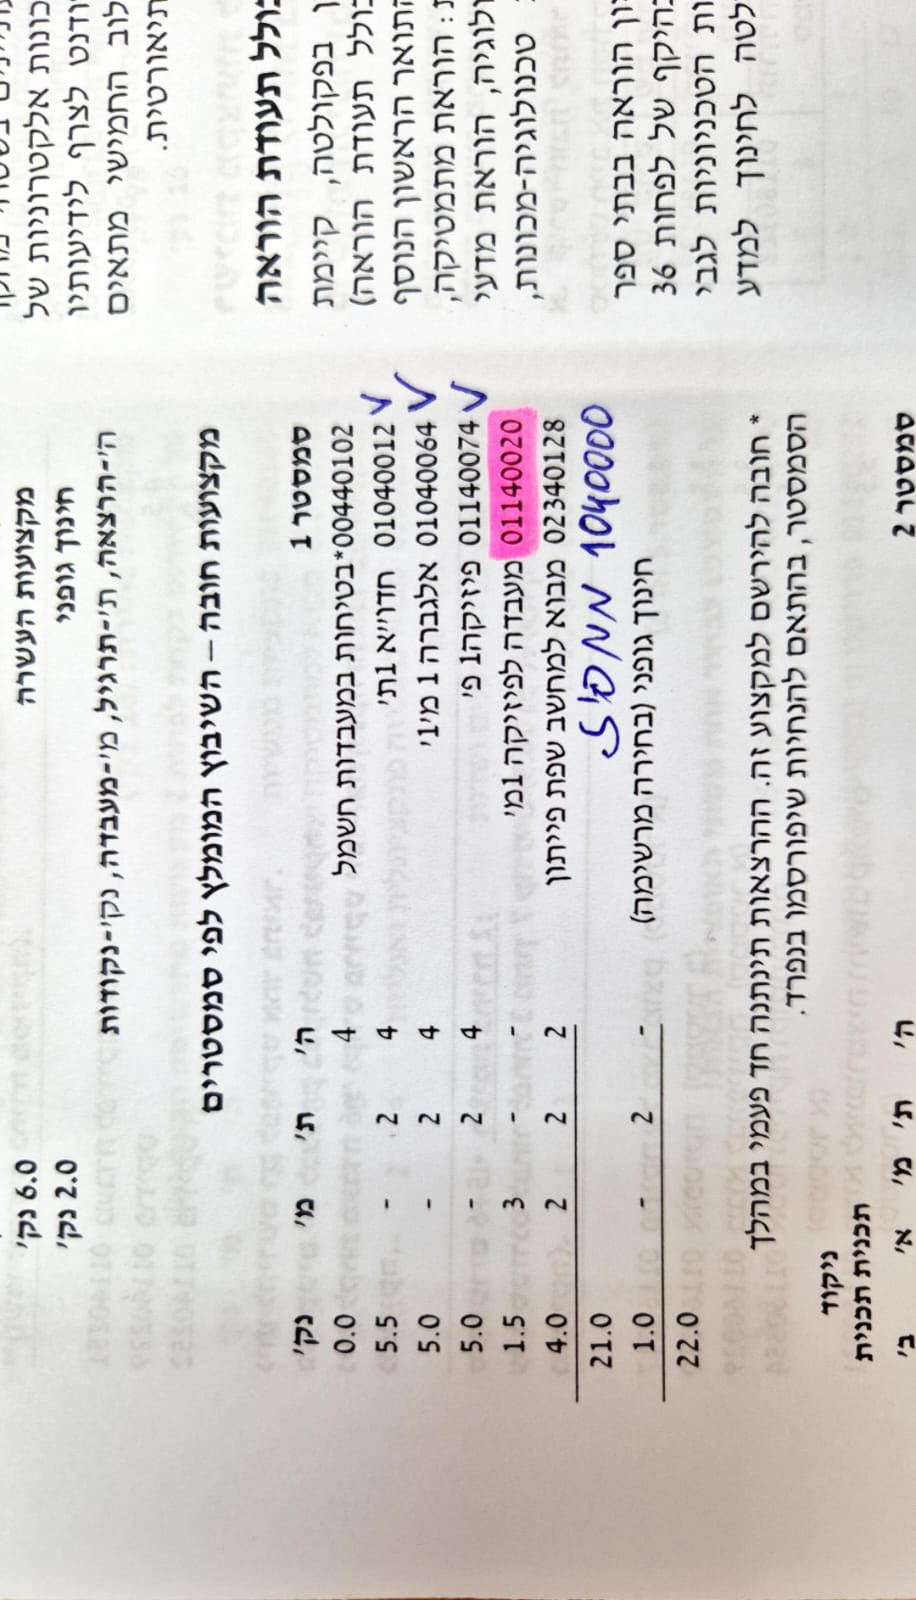

In [50]:
semester = [1040012, 1040064, 1140074, 2340128, 1040000]

text = calculate_rating(semester)

#for slot in count:
#  print(f'{slot}: {count[slot]}')

with open('semester1.csv', 'w', encoding='utf-8') as f:
    f.write(text)